In [2]:
import numpy as np
import scipy
from scipy.ndimage import gaussian_filter1d
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
%matplotlib inline
import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp
import database
db = database.db

import change_point_analysis as cpa
import change_point_plot as cpp

In [3]:
data_dir_full=db.query('owner=="roman"')['data_dir_full'][0]
data_dir_full
db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False).head(10)

data_dir_full  \
animal_name                                                        
e13_26m1    0  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_26...   
e15_13f1    0  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            1  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            2  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            3  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
e13_26m1    1  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_26...   
e13_16f1    7  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_16...   
e13_26m1    2  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_26...   
e16_3m2     3  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m...   
e16_3m1     0  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m...   

                     sess_name animal_name.1        date  \
animal_name                                                
e13_26m1    0  e13_26m1_210913      e13_26m1  2021-09-13   
e15_13f1    0  e15_13f1_220117      e15_13f1  2022-01-17   
            1  e15_13f1_220118      e15_13f1  2022-01-18   
            2  e15_13f1_220119      e15_13f1  2022-01-19   
            3  e15_13f1_220120      e15_13f1  2022-01-20   
e13_26m1    1  e13_26m1_211019      e13_26m1  2021-10-19   
e13_16f1    7  e13_16f1_210328      e13_16f1  2021-03-28   
e13_26m1    2  e13_26m1_211116      e13_26m1  2021-11-16   
e16_3m2     3   e16_3m2_211213       e16_3m2  2021-12-13   
e16_3m1     0   e16_3m1_210111       e16_3m1  2021-01-11   

                                    behavior  performance  ntrials  \
animal_name                                                          
e13_26m1    0                    alternation     0.956522       69   
e15_13f1    0                    alternation     0.617647       34   
            1   ['alternation' 'linearMaze']     0.740741       27   
            2  ['alternation' 'alternation']     0.721311       61   
            3   ['alternation' 'linearMaze']     0.800000       45   
e13_26m1    1  ['alternation' 'alternation']     0.730769       78   
e13_16f1    7                    alternation     0.850000       20   
e13_26m1    2   ['alternation' 'linearMaze']     0.850000       20   
e16_3m2     3  ['alternation' 'alternation']     0.703704       54   
e16_3m1     0                    alternation     0.882353       17   

               ngoodtrials  n_neurons  n_pyr_putative  owner   data_root  
animal_name                                                               
e13_26m1    0           69        482             422  roman  roman_data  
e15_13f1    0           34        376             333  roman  roman_data  
            1           27        363             318  roman  roman_data  
            2           61        343             288  roman  roman_data  
            3           45        303             248  roman  roman_data  
e13_26m1    1           78        271             228  roman  roman_data  
e13_16f1    7           20        211             174  roman  roman_data  
e13_26m1    2           20        209             173  roman  roman_data  
e16_3m2     3           54        207             163  roman  roman_data  
e16_3m1     0           17        203             162  roman  roman_data

In [4]:
# data_dir_full = '/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/'
# data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][0]
data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][0]

In [ ]:
import place_field_analysis as pf
reload(pf)
pf.get_fr_map_shuffle_wrapper(data_dir_full,nrepeats=1000, dosave=False)

 77%|███████▋  | 768/1000 [04:23<01:20,  2.88it/s]

In [4]:
# load data
# mat_to_return=prep.load_stuff(data_dir_full)
# sessionPulses=mat_to_return['sessionPulses']
# filtered = mat_to_return['filtered']
# behavior=mat_to_return['behavior']
# ripples = mat_to_return['ripples']


prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
spk_beh_df=prep_res['spk_beh_df']
cell_cols_d = prep_res['cell_cols_d']
beh_df = prep_res['beh_df'].as_dataframe()
beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']

In [5]:
import place_field_analysis as pf
reload(pf)
reload(pa)

<module 'place_cell_analysis' from '/mnt/home/szheng/projects/util_code/place_cell_analysis.py'>

In [6]:
cell_cols = cell_cols_d['pyr']
nbins = 100
spk_beh_df,lin_bins = dpp.add_lin_binned(spk_beh_df,nbins=nbins)
fr_map_d,count_d,occu_d = pf.ratemap_from_spk_beh_df_alltrialtype(spk_beh_df,cell_cols,speed_thresh=1,nbins=nbins,smth_in_bin=2.5)
# spk_beh_df['lin_binned'],bins = pd.cut(spk_beh_df['lin'],nbins,retbins=True,labels=False)



fr_map_peaks_d = {}
field_res_d = {}
for key in fr_map_d.keys():

    fr_map = fr_map_d[key]
    count = count_d[key]
    occu = occu_d[key]
    field_res_d[key] =pf.get_field_peaks_one_trialtype(fr_map,count,occu,min_count=3,min_rate=0.5,alpha=0.05)
    

In [7]:
reload(pa)
fr_map_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols_d['pyr'],trialtype_key='visitedArm',speed_thresh=1.,order=['smooth','divide'])



cant format into a dataframe
cant format into a dataframe


<AxesSubplot:xlabel='lin_binned'>

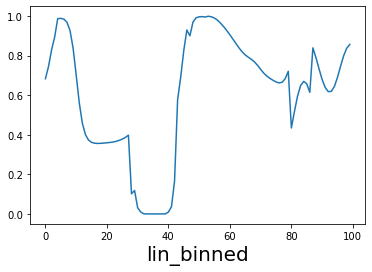

In [78]:
field_res_d[0,0]['pvals_df'].loc[174].plot()

In [8]:
tt=1
count_trial = fr_map_dict[tt][1]

occu_trial = fr_map_dict[tt][2]
fr_map_trial = fr_map_dict[tt][0]
fr_map_trial_reshape = fr_map_trial.reshape(-1,fr_map_trial.shape[-1])

# population cross correlation

In [ ]:
def get_a_lead_b(a,b,nbins,mode='same'):
    '''
    nbins: only consider shifts within this range
    '''
    corr = scipy.signal.correlate(a,b,mode=mode)
    lags = scipy.signal.correlation_lags(a.shape[0],b.shape[0],mode=mode)
    lags_mask = (lags >=-(nbins-1)) & (lags <=nbins-1)
    center = (len(corr[lags_mask])-1) / 2
    com = na.get_com(corr[lags_mask][None,:],axis=1)
#     com = np.argmax(corr[lags_mask])
    lead = com - center
    return lead
    
    

In [ ]:
ntrials = fr_map_trial_reshape.shape[1]

In [150]:
def get_lead_mat(fr_map_trial):
    ntrials = fr_map_trial.shape[-1]
    fr_map_trial_reshape = fr_map_trial.reshape(-1,ntrials)
    com_mat = np.zeros((ntrials,ntrials))
    for i in range(ntrials-1):
        for j in range(i+1,ntrials):
            a=fr_map_trial_reshape[:,i]
            b=fr_map_trial_reshape[:,j]
            com_mat[i,j] = get_a_lead_b(a,b,fr_map_trial.shape[1],mode='same')
    return com_mat

In [202]:
lead_mat_one=get_lead_mat(fr_map_trial[cell_cols==58])

In [208]:
def get_lead_mat_all_neurons(fr_map_trial):
    lead_mat_all=[]
    for n in range(fr_map_trial.shape[0]):
        lead_mat_one = get_lead_mat(fr_map_trial[[n]])
        lead_mat_all.append(lead_mat_one)
    lead_mat_all = np.stack(lead_mat_all)
    return lead_mat_all

In [209]:
lead_mat_all = get_lead_mat_all_neurons(fr_map_trial)

lead_mat_median = np.nanmedian(lead_mat_all,axis=0)

/mnt/home/szheng/projects/nmf_analysis/nmf_analysis.py:364: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(inds * mat,axis=axis) / np.sum(mat,axis=axis)


<AxesSubplot:>

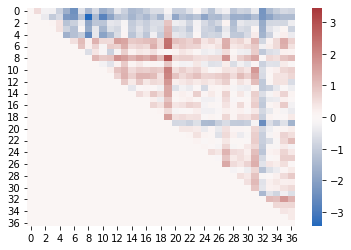

In [212]:
sns.heatmap(lead_mat_median,cmap='vlag',vmax = np.abs(lead_mat_median).max(),center=0)

<AxesSubplot:>

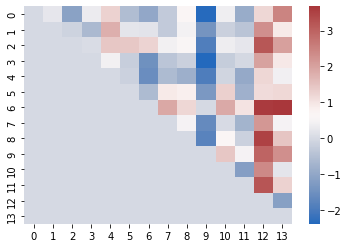

In [142]:
sns.heatmap(com_mat * 2.2,cmap='vlag')

## Sweep multiple sessions

In [235]:
subdb['behavior'].apply(lambda x:'[' in x)

animal_name   
e13_26m1     0    False
             1     True
             2     True
             3     True
             4    False
Name: behavior, dtype: bool

In [237]:
spk_beh_df

,1,2,3,4,5,6,7,8,9,10,...,trial,task_index,task,speed,vel_x,vel_y,visitedArm,correct,v,lin_binned
Time (s),,,,,,,,,,,,,,,,,,,,,
15103.047333,1,220,167,169,306,218,351,247,306,155,...,NaN,1,alternation,0.000000,0.000000,0.000000,NaN,NaN,NaN,79
15116.013933,2,496,405,346,663,469,603,505,617,315,...,NaN,1,alternation,0.000258,-0.000256,0.000024,NaN,NaN,NaN,79
15138.128167,3,474,292,279,444,345,473,375,397,219,...,NaN,1,alternation,0.000514,-0.000512,0.000048,NaN,NaN,NaN,79
15144.995567,0,146,91,97,144,89,144,132,101,77,...,NaN,1,alternation,0.000770,-0.000766,0.000072,NaN,NaN,NaN,79
15146.245833,0,75,53,45,56,48,50,49,39,29,...,NaN,1,alternation,0.001023,-0.001019,0.000094,NaN,NaN,NaN,79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16749.099900,0,0,0,0,0,4,1,0,0,2,...,32.0,1,alternation,0.006189,0.004005,0.004719,0.0,1.0,NaN,99
16749.133233,0,3,2,1,1,1,1,1,1,2,...,32.0,1,alternation,0.004964,0.003216,0.003781,0.0,1.0,NaN,99
16749.166567,0,2,1,0,0,1,2,0,2,2,...,32.0,1,alternation,0.003730,0.002419,0.002839,0.0,1.0,NaN,99


In [243]:
reload(pa)

<module 'place_cell_analysis' from '/mnt/home/szheng/projects/util_code/place_cell_analysis.py'>

In [253]:
fr_map_dict[1].keys()

dict_keys([0, 1])

In [256]:
nbins

100

In [284]:
%%time
subdb = db.query('animal_name=="e13_26m1"')
subdb = subdb.loc[subdb['behavior'].apply(lambda x:'[' in x)]
lead_mat_l = []
iii=0
for data_dir_full in subdb['data_dir_full']:
    prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
    spk_beh_df=prep_res['spk_beh_df']
    cell_cols_d = prep_res['cell_cols_d']
    spk_beh_df = dpp.add_lin_binned(spk_beh_df,nbins=nbins)
    spk_beh_df = spk_beh_df.query('task_index==1') # only familiar
#     fr_map_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols_d['pyr'],trialtype_key='visitedArm',speed_thresh=1.,order=['smooth','divide'])
    fr_map_dict = pa.get_fr_map_trial_multi_task(spk_beh_df,cell_cols_d['pyr'],speed_thresh=1.,order=['smooth','divide'])[1]
    for tt in fr_map_dict.keys():
#         fr_map_trial = fr_map_dict[tt][0] # if using get_fr_map_trial
        fr_map_trial = fr_map_dict[tt] # if using get_fr_map_trial_multi_task
#         lead_mat = get_lead_mat(fr_map_trial)
        lead_mat = get_lead_mat_all_neurons(fr_map_trial)
        lead_mat = np.nanmedian(lead_mat,axis=0)
        lead_mat = pd.DataFrame(lead_mat)
        print(iii)
        lead_mat_l.append(lead_mat)
        iii=iii+1
        



cant format into a dataframe
cant format into a dataframe


/mnt/home/szheng/projects/nmf_analysis/nmf_analysis.py:364: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(inds * mat,axis=axis) / np.sum(mat,axis=axis)


0
1
cant format into a dataframe
cant format into a dataframe
2
3


/mnt/home/szheng/projects/nmf_analysis/nmf_analysis.py:364: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(inds * mat,axis=axis) / np.sum(mat,axis=axis)


cant format into a dataframe
cant format into a dataframe


/mnt/home/szheng/projects/nmf_analysis/nmf_analysis.py:364: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(inds * mat,axis=axis) / np.sum(mat,axis=axis)


4
5
CPU times: user 12.2 s, sys: 852 ms, total: 13 s
Wall time: 13 s


In [285]:
max_ntrials = np.max([lead_mat.shape[0] for lead_mat in lead_mat_l])

lead_mat_l_pad = [lead_mat.reindex(np.arange(max_ntrials)).reindex(np.arange(max_ntrials),axis=1) for lead_mat in lead_mat_l]

lead_mat_l_pad_tensor = np.stack([lead_mat.values for lead_mat in lead_mat_l_pad])

lead_mat_average = np.nanmean(lead_mat_l_pad_tensor,axis=0)
lead_mat_median = np.nanmedian(lead_mat_l_pad_tensor,axis=0)

In [815]:
def diverging_heatmap(X,quantile=0.99,**kwargs):
    vmax = np.quantile(np.abs(X),quantile)
    ax=sns.heatmap(X,cmap='vlag',center=0,vmin=-vmax,vmax=vmax)
    return ax
    

<AxesSubplot:>

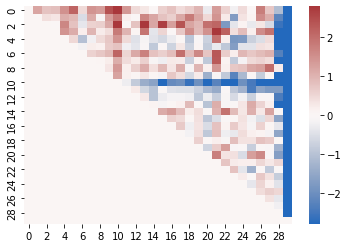

In [301]:
diverging_heatmap(lead_mat_average,quantile=0.95)

<AxesSubplot:>

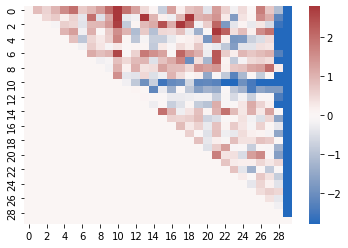

In [299]:
diverging_heatmap(lead_mat_median,quantile=0.95)

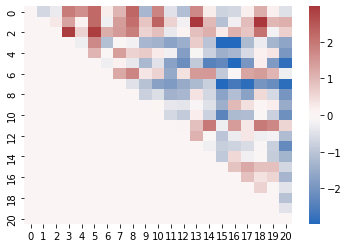

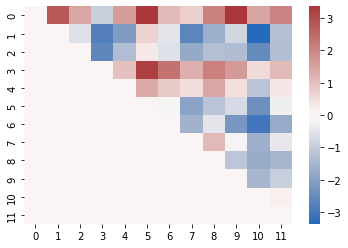

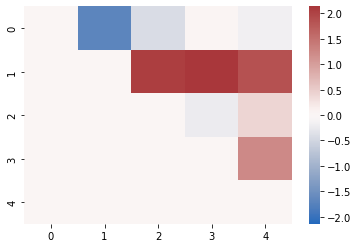

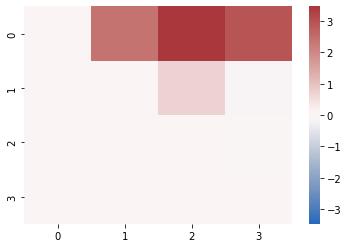

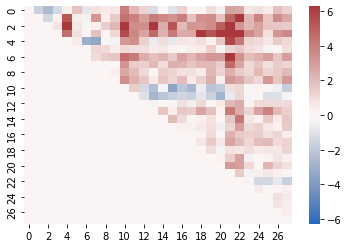

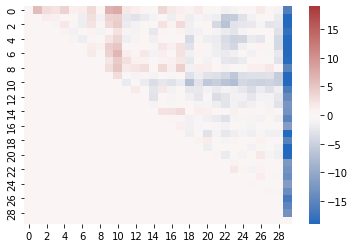

In [303]:
for lead_mat in lead_mat_l:
    plt.figure()
    diverging_heatmap(lead_mat)


In [100]:
a=fr_map_trial_reshape[:,0]
b=fr_map_trial_reshape[:,1]

In [110]:
# a = np.arange(100)
# b = np.arange(1,101)
# b = np.arange(100)
get_a_lead_b(a,b,100,mode='same')

array([-1.47375851])

In [53]:
reload(na)

<module 'nmf_analysis' from '/mnt/home/szheng/projects/nmf_analysis/nmf_analysis.py'>

In [92]:
a = np.array([1,2,3,4,0])
b = np.array([0,1,2,3,4])

In [97]:
nbins = 101
mode = 'same'
corr = scipy.signal.correlate(a,b,mode=mode)
lags = scipy.signal.correlation_lags(a.shape[0],b.shape[0],mode=mode)
lags_mask = (lags >=-(nbins-1)) & (lags <=nbins-1)
center = (len(corr[lags_mask])-1) / 2
# com = na.get_com(corr[lags_mask][None,:],axis=1)
com = np.argmax(corr[lags_mask])
lead = com - center

In [94]:
corr

array([20, 30, 20, 11,  4])

In [98]:
lead

-1.0

In [96]:
lags[np.argmax(corr)]

-1

In [88]:
com

array([1.87692308])

In [79]:
com

array([99.33333333])

In [68]:
corr.shape

(199,)

In [71]:
center

99.5

In [73]:
np.nonzero(lags==0)

(array([99]),)

In [55]:
corr[lags_mask]

array([   100,    299,    596,    990,   1480,   2065,   2744,   3516,
         4380,   5335,   6380,   7514,   8736,  10045,  11440,  12920,
        14484,  16131,  17860,  19670,  21560,  23529,  25576,  27700,
        29900,  32175,  34524,  36946,  39440,  42005,  44640,  47344,
        50116,  52955,  55860,  58830,  61864,  64961,  68120,  71340,
        74620,  77959,  81356,  84810,  88320,  91885,  95504,  99176,
       102900, 106675, 110500, 114374, 118296, 122265, 126280, 130340,
       134444, 138591, 142780, 147010, 151280, 155589, 159936, 164320,
       168740, 173195, 177684, 182206, 186760, 191345, 195960, 200604,
       205276, 209975, 214700, 219450, 224224, 229021, 233840, 238680,
       243540, 248419, 253316, 258230, 263160, 268105, 273064, 278036,
       283020, 288015, 293020, 298034, 303056, 308085, 313120, 318160,
       323204, 328251, 333300, 328350, 323400, 318451, 313504, 308560,
       303620, 298685, 293756, 288834, 283920, 279015, 274120, 269236,
      

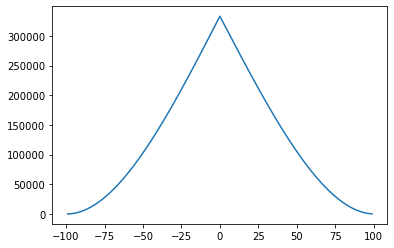

In [39]:
%matplotlib inline
lags = scipy.signal.correlation_lags(a.shape[0],b.shape[0])
plt.plot(lags,scipy.signal.correlate(a,b))

In [16]:
fr_map_trial_reshape.shape

(42200, 33)

# better field detection

In [326]:
# nrepeats = 1000
# roll_inds = np.random.randint(5,nbins-5,size=(nrepeats))

# %time count_roll = count_trial_long.groupby(level=0).apply(lambda x:np.array([np.roll(x,i,axis=0) for i in roll_inds]))
                                                           

# reload(pf)
# %time count_roll = pf.get_field_by_trial_shuffle(fr_map_trial,count_trial,occu_trial,cell_cols,nrepeats=1000)

# dt=0.033
# fr_shuffle = count_roll / (occu_d[0,0] * dt)

# fr_shuffle

<AxesSubplot:>

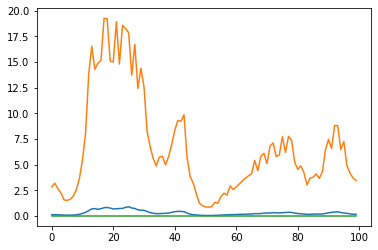

In [28]:
%matplotlib inline
fr_shuffle.loc[174].mean().plot()
fr_shuffle.loc[174].quantile(0.99,axis=0).plot()
fr_shuffle.loc[174].quantile(0.01,axis=0).plot()


In [10]:
nrepeats=100
roll_inds = np.random.randint(50,spk_beh_df.shape[0]-50,size=nrepeats)
# %time spk_roll = np.concatenate([np.roll(spk_beh_df[cell_cols],i,axis=0) for i in roll_inds],axis=0)

In [9]:
_,spk_beh_df=dpp.group_into_trialtype(spk_beh_df)

In [13]:
beh_part=spk_beh_df[['lin','trial_type','speed']]

In [56]:
%%time
fr_map_null_d_all = {(0,0):{},(0,1):{}}
for n in range(nrepeats):
    i = roll_inds[n]
    spk_df_roll =pd.DataFrame(np.roll(spk_beh_df[cell_cols],i,axis=0),columns=cell_cols,index=spk_beh_df.index)
    spk_df_roll = pd.concat([spk_df_roll,beh_part],axis=1)
    fr_map_null_d,_,_,_ = pf.ratemap_from_spk_beh_df_alltrialtype(spk_df_roll,cell_cols,speed_thresh=1,nbins=100,smth_in_bin=2.5)
    for k,val in fr_map_null_d.items():
        fr_map_null_d_all[k][n]=val

CPU times: user 1min 19s, sys: 1min 11s, total: 2min 30s
Wall time: 2min 30s


In [72]:
data_dir_full

'/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913'

In [668]:
sys.path.append('/mnt/home/szheng/projects/util_code/hpc/')
import create_fr_map_shuffle as cfms
reload(cfms)
reload(pf)

67 sessions!


<module 'place_field_analysis' from '/mnt/home/szheng/projects/util_code/place_field_analysis.py'>

In [76]:
reload(pf)
save_fn = os.path.join(data_dir_full,'py_data','fr_map_null.p')
%time pf.get_fr_map_shuffle(spk_beh_df,cell_cols,nrepeats=1000,dosave=True,save_fn=save_fn)

100%|██████████| 1000/1000 [25:01<00:00,  1.50s/it]


saved at /mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/fr_map_null.p
CPU times: user 13min 16s, sys: 11min 49s, total: 25min 6s
Wall time: 25min 6s


{(0,
  0.0): lin_binned         0          1          2          3          4          5   \
 0   1.0      0.007894   0.011235   0.016073   0.020732   0.024417   0.026872   
     2.0      0.020863   0.018310   0.014426   0.010452   0.007079   0.004530   
     3.0      0.066869   0.083441   0.105041   0.122374   0.132614   0.136341   
     27.0    14.721391  14.652271  14.587341  14.570896  14.596855  14.640268   
     29.0     3.422030   3.434841   3.409962   3.330052   3.219409   3.109060   
 ...               ...        ...        ...        ...        ...        ...   
 999 476.0    0.264050   0.283644   0.298198   0.292585   0.268665   0.234512   
     477.0    0.060094   0.050055   0.037308   0.027418   0.021823   0.020298   
     478.0    0.007841   0.012924   0.021313   0.031192   0.041344   0.050917   
     479.0    0.564353   0.571165   0.573944   0.567010   0.552117   0.532363   
     480.0    1.179221   1.153232   1.127262   1.119582   1.131321   1.155758   
 
 lin_binned   

In [10]:
fr_map_null = pickle.load(open('/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/fr_map_null.p','rb'))



In [13]:
fr_map_null

{(0,
  0.0): lin_binned         0          1          2          3          4          5   \
 0   1.0      0.007894   0.011235   0.016073   0.020732   0.024417   0.026872   
     2.0      0.020863   0.018310   0.014426   0.010452   0.007079   0.004530   
     3.0      0.066869   0.083441   0.105041   0.122374   0.132614   0.136341   
     27.0    14.721391  14.652271  14.587341  14.570896  14.596855  14.640268   
     29.0     3.422030   3.434841   3.409962   3.330052   3.219409   3.109060   
 ...               ...        ...        ...        ...        ...        ...   
 999 476.0    0.264050   0.283644   0.298198   0.292585   0.268665   0.234512   
     477.0    0.060094   0.050055   0.037308   0.027418   0.021823   0.020298   
     478.0    0.007841   0.012924   0.021313   0.031192   0.041344   0.050917   
     479.0    0.564353   0.571165   0.573944   0.567010   0.552117   0.532363   
     480.0    1.179221   1.153232   1.127262   1.119582   1.131321   1.155758   
 
 lin_binned   

In [11]:
fr_map_trial = fr_map_dict[0][0]
fr_map_trial_df=pf.fr_map_trial_to_df(fr_map_trial,cell_cols)

In [1]:
# sig_thesh_map = fr_map_null[0,0].groupby(level=1).quantile(0.99)
sig_thesh_map = fr_map_null[0,0].groupby(level=1).max()

NameError: name 'fr_map_null' is not defined

<AxesSubplot:xlabel='lin_binned'>

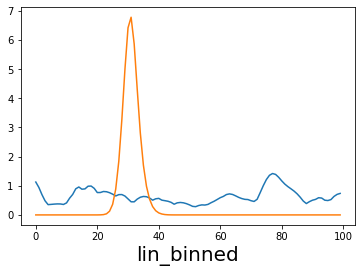

In [639]:
%matplotlib inline
uid = 3
sig_thesh_map.loc[uid].plot()
fr_map_trial_df.loc[uid].loc[:,16].plot()

In [13]:
min_fr = 1
issig_trial = (fr_map_trial_df > sig_thesh_map.stack().values[:,None]) & (fr_map_trial_df > min_fr)

<AxesSubplot:>

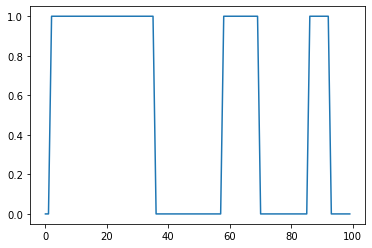

In [55]:
issig_trial.loc[uid][15].astype(int).plot()

<AxesSubplot:xlabel='lin_binned'>

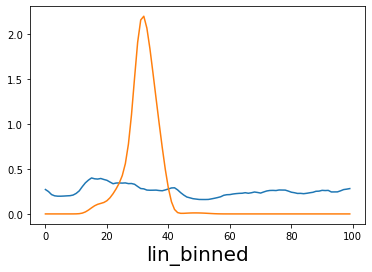

In [206]:
%matplotlib inline
uid = 3
sig_thesh_map.loc[uid].plot()
# fr_map_trial_df.loc[uid].loc[:,1].plot()
fr_map_d[0,0].loc[uid].plot()

<AxesSubplot:xlabel='lin_binned'>

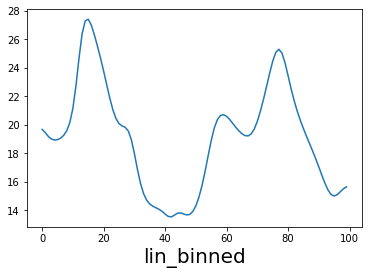

In [200]:
fr_map_d[0,0].loc[27].plot()

<AxesSubplot:>

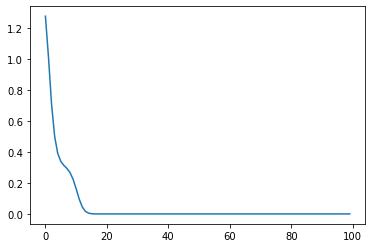

In [103]:
fr_map_trial_df.loc[1][32].plot()

In [74]:
# issig_agg=issig_trial.any(axis=1).unstack()

# ma = np.diff(issig_agg.astype(int),prepend=0,append=0)

<AxesSubplot:>

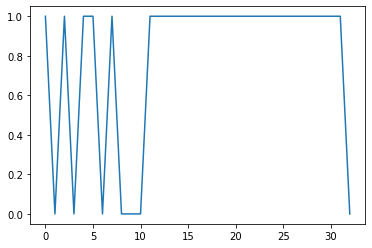

In [58]:
issig_trial.loc[27].loc[5].astype(int).plot()

In [104]:
# detect field using the significant chunks in each trial
issig_trial_pos_cols =issig_trial.stack().unstack(level=1)
ma = np.diff(issig_trial_pos_cols.astype(int),prepend=0,append=0)
start_ind,start_pos=np.nonzero(ma==1)
end_ind,end_pos=np.nonzero(ma==-1)[0],np.nonzero(ma==-1)[1] - 1 # -1, because in pd loc, the right end is included

start_ind = issig_trial_pos_cols.index.values[start_ind]
all_fields_bounds=pd.DataFrame(np.array([start_ind,start_pos,end_pos]).T,columns=['uid','start','end'])
all_fields_bounds.index=pd.MultiIndex.from_tuples(all_fields_bounds['uid'])
all_fields_bounds = all_fields_bounds.drop('uid',axis=1)

field_index = all_fields_bounds.groupby(level=(0,1)).cumcount()
all_fields_bounds['field_index'] = field_index

width_thresh_in_bin = (4,30)
width = all_fields_bounds['end']-all_fields_bounds['start']
width_mask = (width >= width_thresh_in_bin[0]) & (width <= width_thresh_in_bin[1])

all_fields_bounds = all_fields_bounds.loc[width_mask]


In [244]:
# all_fields_bounds_pivot = all_fields_bounds.pivot(columns='field_index')

In [21]:
# gpb = all_fields_bounds_pivot.groupby(level=0)

In [ ]:
# now want to test the overlap of the stacked field ranges
# min of next start - prev end, start - prev start

In [319]:
uid = 29

In [260]:
start_one_neuron = all_fields_bounds.loc[uid]['start'].values[:,None]
end_one_neuron = all_fields_bounds.loc[uid]['end'].values[:,None]

field_bounds_one_neuron = all_fields_bounds.loc[uid]

In [294]:
field_bounds_one_neuron['midpoint'] =(field_bounds_one_neuron['start'] +field_bounds_one_neuron['end']) / 2

/tmp/ipykernel_607939/12910675.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_bounds_one_neuron['midpoint'] =(field_bounds_one_neuron['start'] +field_bounds_one_neuron['end']) / 2


In [15]:
def get_peak_com_from_all_fields_bounds(fr_map_trial_df,all_fields_bounds):
    peak_l = []
    com_l = []
    for ii,row in all_fields_bounds.iterrows():
        uid=ii[0]
        tt=ii[1]
        peak = fr_map_trial_df.loc[(uid,slice(None))][tt].loc[row['start']:row['end']].idxmax()
        peak_l.append(peak)
        
        section = fr_map_trial_df.loc[(uid,slice(None))][tt].loc[row['start']:row['end']]
        inds = section.index
        com =na.get_com(section.values[:,None],axis=0)[0]

        com = inds[int(com)] if not np.isnan(com) else np.nan
        com_l.append(com)
    all_fields_bounds['peak'] = peak_l
    all_fields_bounds['com'] = com_l
    
    return all_fields_bounds

In [105]:
%%time
all_fields_bounds = get_peak_com_from_all_fields_bounds(fr_map_trial_df,all_fields_bounds)

CPU times: user 14.6 s, sys: 3.2 ms, total: 14.6 s
Wall time: 14.6 s


<AxesSubplot:>

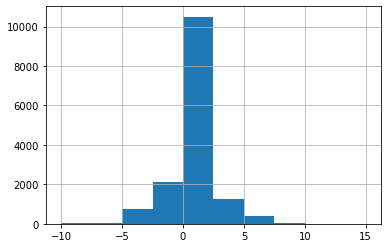

In [356]:
(all_fields_bounds['peak']-all_fields_bounds['com']).hist() 
# do it in different sections of the experiment

In [396]:
all_fields_bounds.groupby(level=0).count()['start']<2

3.0      False
27.0     False
29.0     False
30.0     False
31.0     False
         ...  
475.0    False
476.0    False
478.0    False
479.0    False
480.0    False
Name: start, Length: 390, dtype: bool

In [493]:
def cluster_field_one_neuron(fields_bounds_one_neuron,cluster_key='peak',model=BayesianGaussianMixture,manual_merge_thresh=5,model_kws={'mean_precision_prior':0.0001,'max_iter':800}):
    n_fields_new = len(fields_bounds_one_neuron['field_index'].unique())+1 # max number of fields per trial + 1

    if fields_bounds_one_neuron.shape[0]==1:
        return np.array([0])
    else:
        while n_fields_new > fields_bounds_one_neuron.shape[0]:
            n_fields_new = n_fields_new-1
        location_to_be_clustered=fields_bounds_one_neuron[cluster_key].values[:,None]
        mdl = model(n_components=n_fields_new,**model_kws)
        cl = mdl.fit_predict(location_to_be_clustered)

        cl = scipy.stats.rankdata(cl,method='dense')-1 # reindex

        return cl
    


In [72]:
from sklearn.cluster import AgglomerativeClustering

In [18]:
# combine field
def combine_field_one_neuron(fields_bounds_one_neuron,combine_key='field_index_cl'):
    gpb=fields_bounds_one_neuron.groupby(combine_key)
    range_combined = pd.DataFrame([gpb['start'].min(),gpb['end'].max()]).T
    return range_combined

    

In [29]:
# interpolate across trials
def interploate_field_across_trials_one_neuron(fields_bounds_one_neuron,trial_inds,combine_key='field_index_cl'):
    '''
    within one trial, fields with the same combine_key would be combined
    '''
    # (n_trial x field_index_cl x [start,end]) x 1

    fields_bounds_one_neuron_merged=fields_bounds_one_neuron.groupby(['trial',combine_key]).apply(lambda x:pd.DataFrame({'start':[x['start'].min()],'end':[x['end'].max()]}).T) 
    # n_trial x ([start,end] x field_index_cl)
    fields_bounds_one_neuron_merged_pivot=fields_bounds_one_neuron_merged.unstack().droplevel(axis=1,level=0).unstack(level=1)
    # make sure all trials have the same indices
    fields_bounds_one_neuron_merged_pivot=fields_bounds_one_neuron_merged_pivot.reindex(trial_inds)
    
    fields_bounds_one_neuron_merged_pivot_interp=fields_bounds_one_neuron_merged_pivot.interpolate(limit_direction='both').astype(int)
    return fields_bounds_one_neuron_merged_pivot_interp
    
    

In [431]:
cl

array([1, 1, 1, 1, 0])

In [474]:

gpb=all_fields_bounds.groupby(level=0)
cl_all=[]
for k,val in gpb:
    cl=cluster_field_one_neuron(val,cluster_key='com',model=Kde_Peak_Cluster,model_kws=kde_kws)
    cl_all.extend(cl)

In [672]:
all_fields_bounds

start end  field_index  peak  com  field_index_cl  trial
3.0   0     14  25            0    18   19               0      0
      1     20  29            0    25   24               0      1
      2     27  32            0    30   29               0      2
      9     31  39            0    36   35               1      9
      10    31  39            0    35   34               1     10
...        ...  ..          ...   ...  ...             ...    ...
480.0 28    79  89            0    84   83               2     28
      29    77  91            0    85   84               2     29
      30    77  90            0    84   83               2     30
      31    70  91            0    78   78               1     31
      32    68  87            0    74   76               1     32

[15181 rows x 7 columns]

In [696]:
del Kde_Peak_Cluster
from mode_cluster import Kde_Peak_Cluster
del pf
import place_field_analysis as pf

In [494]:
kde_kws = {'bw_method':0.1,'allposbins':fr_map_d[0,0].columns,'peak_dist_thresh':6}
kde_cl = Kde_Peak_Cluster(**kde_kws)
%time cl_all = all_fields_bounds.groupby(level=0).apply(lambda x:cluster_field_one_neuron(x,cluster_key='com',model=Kde_Peak_Cluster,model_kws=kde_kws))
all_fields_bounds['field_index_cl']=np.concatenate(cl_all.values)
all_fields_bounds['trial'] = all_fields_bounds.index.get_level_values(1)

CPU times: user 297 ms, sys: 0 ns, total: 297 ms
Wall time: 296 ms


In [495]:
# %%time
# gpb = all_fields_bounds.groupby(level=0)
# range_combined_all = gpb.apply(lambda x:combine_field_one_neuron(x,combine_key='field_index_cl'))

In [496]:
trial_inds = fr_map_trial_df.columns
gpb = all_fields_bounds.groupby(level=0)
%time all_fields_bounds_merged_pivot_interp = gpb.apply(lambda x:interploate_field_across_trials_one_neuron(x,trial_inds,combine_key='field_index_cl')) 




all_fields_bounds_merged_interp = all_fields_bounds_merged_pivot_interp.stack(level=1)

CPU times: user 12.7 s, sys: 17.8 ms, total: 12.7 s
Wall time: 12.7 s


In [497]:
%%time
all_fields_bounds_merged_interp = get_peak_com_from_all_fields_bounds(fr_map_trial_df,all_fields_bounds_merged_interp)



/mnt/home/szheng/projects/nmf_analysis/nmf_analysis.py:365: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(inds * mat,axis=axis) / np.sum(mat,axis=axis)


CPU times: user 47.1 s, sys: 5.26 ms, total: 47.1 s
Wall time: 47.1 s


In [498]:
all_fields_bounds_merged_interp

end  start  peak   com
         field_index_cl                         
3.0   0  0               25.0   14.0    18  19.0
         1               39.0   31.0    31  31.0
      1  0               29.0   20.0    25  24.0
         1               39.0   31.0    31  31.0
      2  0               32.0   27.0    30  29.0
...                       ...    ...   ...   ...
480.0 31 1               91.0   70.0    78  78.0
         2               90.0   77.0    78  80.0
      32 0               35.0   28.0    34  32.0
         1               87.0   68.0    74  76.0
         2               90.0   77.0    77  80.0

[49896 rows x 4 columns]

In [812]:
# peak_shift = all_fields_peak - all_fields_peak.mean(axis=1).values[:,None]

# import tsp
# from scipy.spatial.distance import pdist,squareform

# dist=squareform(pdist(peak_shift,metric='correlation'))

# path,_=tsp.solve_tsp(dist)

# diverging_heatmap(peak_shift.iloc[path],quantile=0.99)

In [499]:
kk='com'
all_fields_peak = all_fields_bounds_merged_interp[kk].unstack(level=1)
all_fields_peak_mean = all_fields_peak.mean(axis=1)
all_fields_peak_std = all_fields_peak.std(axis=1)

Text(0, 0.5, 'std across trials')

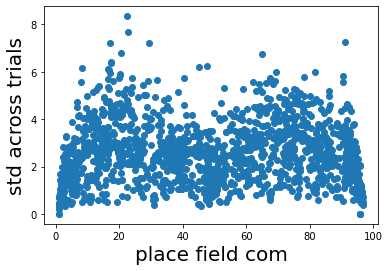

In [500]:
plt.scatter(all_fields_peak_mean,all_fields_peak_std)
plt.xlabel(f'place field {kk}')
plt.ylabel('std across trials')

In [533]:
spkbehdf_onetrialtype=spk_beh_df.loc[spk_beh_df['trial_type']==(0,0)]
spkbehdf_onetrialtype_filter = spkbehdf_onetrialtype.query('speed>5')
mean_speed_trial=spkbehdf_onetrialtype.groupby(['trial','lin_binned'])['speed'].mean().unstack()
mean_speed_trial_filter = spkbehdf_onetrialtype_filter.groupby(['trial','lin_binned'])['speed'].mean().unstack()

Text(0.5, 1.0, 'mean speed filter')

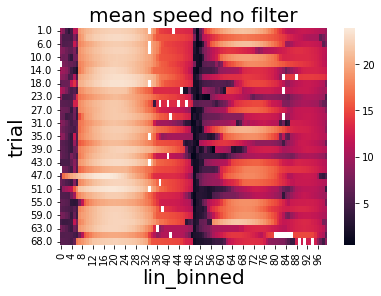

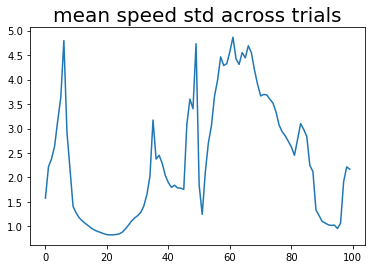

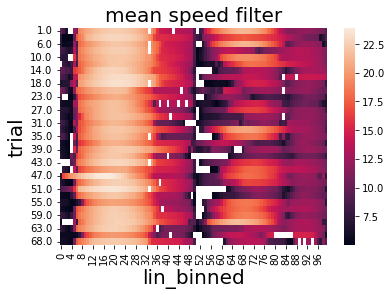

In [534]:
sns.heatmap(mean_speed_trial)
plt.title('mean speed no filter')
plt.figure()
plt.plot(mean_speed_trial.std(axis=0))
plt.title('mean speed std across trials')
plt.figure()
sns.heatmap(mean_speed_trial_filter)
plt.title('mean speed filter')

In [502]:
inds = (all_fields_peak_mean - 50).abs().sort_values().index

In [503]:
all_fields_peak_std.loc[inds].head(20)

       field_index_cl
219.0  2                 2.334154
456.0  2                 1.614284
196.0  3                 1.743560
268.0  3                 4.249554
214.0  2                 1.568511
334.0  3                 1.855408
295.0  3                 2.597336
171.0  2                 1.452532
451.0  0                 1.126484
424.0  0                 1.125463
245.0  2                 1.103713
131.0  2                 1.170525
121.0  2                 2.440087
151.0  1                 1.861899
128.0  2                 0.826160
136.0  2                 1.932062
176.0  2                 1.061553
137.0  1                 1.146470
234.0  1                 1.672075
315.0  2                 0.743223
dtype: float64

In [670]:
res_df = pf.get_field_params_trial(fr_map_trial_df,range_combined_all)

<AxesSubplot:>

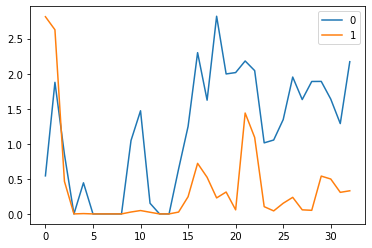

In [620]:
res_df.loc['fr'].loc[3].T.plot()

In [37]:
%matplotlib inline
def plot_field_boundaries(field_bounds_one_neuron,cl_key='field_index_cl'):
    fig,ax=plt.subplots()
    for tt,row in field_bounds_one_neuron.iterrows():
    #     cl=row['cl_from_start']
    #     cl=row['cl_from_ed']
        cl = row[cl_key]            
        ax.axhline(tt,xmin=row['start'] / 100,xmax=row['end'] / 100,color=f'C{cl}')
    ax.set_xlim(0,100)
    return fig,ax

In [470]:
merge_peaks([52])

([52], array([0]))

In [658]:
# del pf
import place_field_analysis as pf
reload(pf)

<module 'place_field_analysis' from '/mnt/home/szheng/projects/util_code/place_field_analysis.py'>

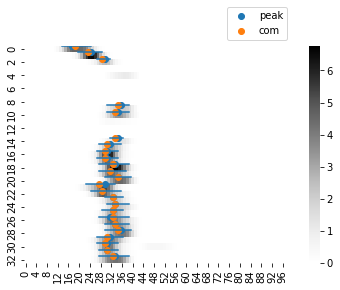

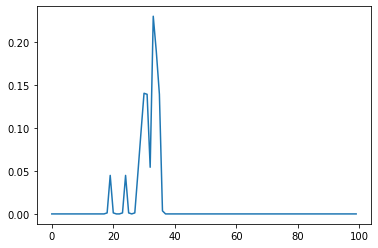

In [660]:
uid = 3#268#100#295#3 # 
fields_bounds_one_neuron = copy.copy(all_fields_bounds.loc[uid])

cluster_key='com'
# location_to_be_clustered=fields_bounds_one_neuron[cluster_key].values[:,None]
location_to_be_clustered=fields_bounds_one_neuron[cluster_key].values

kde_kws = {'bw_method':0.1,'allposbins':fr_map_d[0,0].columns,'peak_dist_thresh':6}
kde_cl = pf.Kde_Peak_Cluster(**kde_kws)
cl,pdf = kde_cl.fit_predict_with_pdf(location_to_be_clustered)

# location_sorted_inds=np.argsort(location_to_be_clustered)
# location_sorted_inds_inds=np.argsort(location_sorted_inds)
# cl=merge_peaks(location_to_be_clustered[location_sorted_inds],peak_dist_thresh=6)[1]
# cl=cl[location_sorted_inds_inds]


# location_to_be_clustered=fields_bounds_one_neuron[['start','end']].values
# mdl=AgglomerativeClustering(n_clusters=None,distance_threshold=20,linkage='complete')
# # mdl=AgglomerativeClustering(n_clusters=5,distance_threshold=None,linkage='complete')
# # mdl = KMeans(4)
# model_kws={'weight_concentration_prior':100.,'mean_precision_prior':0.00001,'max_iter':800}
# mdl = BayesianGaussianMixture(n_components=4,**model_kws)
# cl = mdl.fit_predict(location_to_be_clustered)
# cl = scipy.stats.rankdata(cl,method='dense')-1 # reindex

fields_bounds_one_neuron['field_index_cl']=cl

fig,ax = plot_field_boundaries(fields_bounds_one_neuron,cl_key='field_index_cl')

sns.heatmap(fr_map_trial_df.loc[uid].T,cmap='Greys')
ax.scatter(fields_bounds_one_neuron['peak'],fields_bounds_one_neuron.index,label='peak')
ax.scatter(fields_bounds_one_neuron['com'],fields_bounds_one_neuron.index,label='com')
plt.legend(bbox_to_anchor=[1,1.2])
# fig,ax=plt.subplots()
# for _,row in range_combined_all.loc[uid].iterrows():
#     ax.axhline(0,row['start']/100,row['end']/100)
# ax.set_ylim(-1,1)
# ax.set_xlim(0,100)

plt.figure()
plt.plot(pdf)

In [631]:
gpb=fields_bounds_one_neuron.groupby('field_index_cl')
for k,val in gpb:
    val['trial']

In [634]:
val['start'].min()

53

In [627]:
from sklearn.cluster import KMeans

In [76]:
start_ind,start_pos=np.nonzero(ma==1)
end_ind,end_pos=np.nonzero(ma==-1)[0],np.nonzero(ma==-1)[1] - 1 # -1, because in pd loc, the right end is included

start_ind = issig_agg.index.values[start_ind].astype(int)
all_fields_bounds=pd.DataFrame(np.array([start_ind,start_pos,end_pos]).T,columns=['uid','start','end'])

nfields_max=all_fields_bounds['uid'].value_counts().max()

<AxesSubplot:>

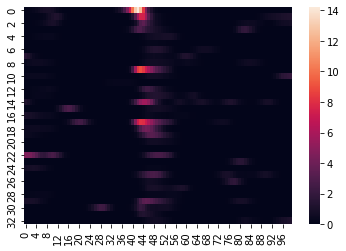

In [239]:
sns.heatmap(fr_map_trial_df.loc[180].T)

In [241]:
all_fields_bounds

,uid,start,end
0,1,0,1
1,1,77,81
2,3,14,40
3,27,0,99
4,29,0,41
...,...,...,...
1240,479,0,5
1241,479,48,99
1242,480,24,35
1243,480,39,41


In [63]:
all_fields_bounds['field_index']=all_fields_bounds.groupby('uid').cumcount()

In [66]:
all_fields_bounds=all_fields_bounds.set_index(['uid','field_index'])

<AxesSubplot:>

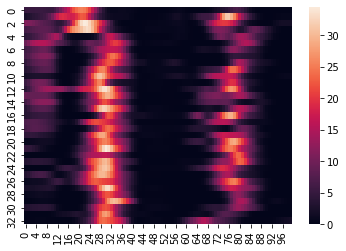

In [242]:
sns.heatmap(fr_map_trial_df.loc[29].T)

In [67]:
all_fields_bounds

start  end
uid field_index            
1   0                0   11
    1               44   55
    2               66   99
3   0               12   41
    1               45   54
...                ...  ...
479 0                0    5
    1               47   99
480 0               24   35
    1               39   41
    2               68   94

[1253 rows x 2 columns]

In [174]:
gpb = all_fields_bounds.groupby(level=0)
merge_thresh =4
fields_all_neuron = []
for k,val in gpb:
    fields_one_neuron = []
    curr_field = val.loc[k,0].values
    for ii in range(val.shape[0]):

        if (ii < val.shape[0]-1) and (np.abs(val.loc[k,ii+1]['start'] - curr_field[1]) <=merge_thresh):
            curr_field = [curr_field[0],val.loc[k,ii+1]['end']]
            
        else:
            curr_field = val.loc[k,ii].values
            fields_one_neuron.append(curr_field)
#     fields_one_neuron.append(curr_field)
    fields_all_neuron.append(fields_one_neuron)
        
#     need_to_merge = (k['start'].shift[1:] - k['end'].iloc[:-1]) <= merge_thresh

In [177]:
fields_all_neuron[2]

[array([ 0, 99])]

In [184]:
all_fields_bounds.loc[27]

,start,end
field_index,,
0,0,99


In [170]:
val

start  end
uid field_index            
480 0               24   35
    1               39   41
    2               68   94

<AxesSubplot:>

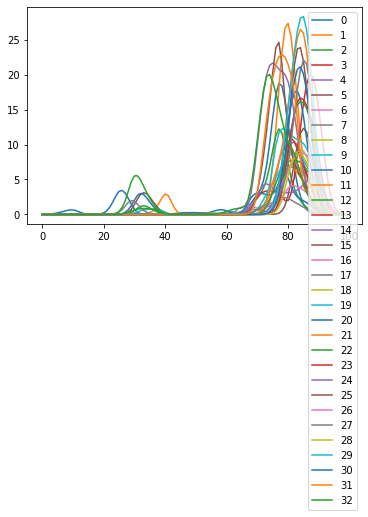

In [161]:
fr_map_trial_df.loc[480].plot()

In [ ]:
def get_field_trial_from_shuffle(fr_map_trial,fr_map_null,cell_cols):
    fr_map_trial_df = pf.fr_map_trial_to_df(fr_map_trial,cell_cols)
    sig_thresh_map = fr_map_null.groupby(level=1).quantile(0.95)
    issig_trial = fr_map_trial_df > sig_thresh_map.stack().values[:,None] #(nneurons x nposbins) x ntrials, binary
    issig_agg = issig_trial.any(axis=1).unstack()

In [60]:
fr_map_null_d_all[0,0] = {n:fr_map_null_d_all[0,0][n] for n in range(nrepeats)}

In [66]:
fr_map_null_df=pd.concat(fr_map_null_d_all[0,0])
null_mean=fr_map_null_df.groupby(level=1).mean()
null_high = fr_map_null_df.groupby(level=1).quantile(0.95)
null_low = fr_map_null_df.groupby(level=1).quantile(0.05)

<AxesSubplot:xlabel='lin_binned'>

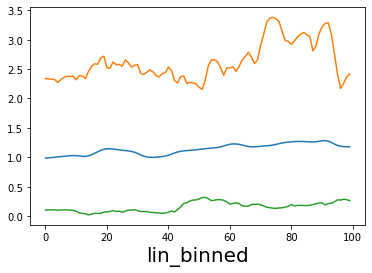

In [71]:
null_mean.loc[174].plot()
null_high.loc[174].plot()
null_low.loc[174].plot()

In [328]:
columns = pd.MultiIndex.from_product([fr_map.columns,fr_map_trial_df.columns])
index = pd.MultiIndex.from_product([fr_map.index,np.arange(nrepeats)])
count_roll=pd.DataFrame(np.concatenate(count_roll.values,axis=0),index=index,columns=columns)

In [329]:
count_roll_sum=count_roll.groupby(level=0,axis=1).sum()

In [330]:
dt = 0.033
fr_shuffle=count_roll_sum / (occu_d[0,0] * dt)

<AxesSubplot:xlabel='lin_binned'>

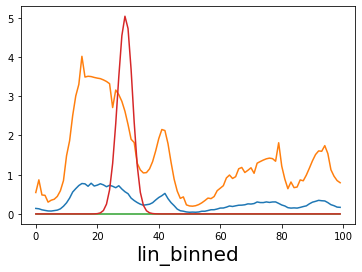

In [337]:
fr_shuffle.loc[174].mean(axis=0).plot()
fr_shuffle.loc[174].quantile(0.99,axis=0).plot()
fr_shuffle.loc[174].quantile(0.01,axis=0).plot()
fr_map_trial_df.loc[174].loc[:,3].plot()

In [36]:
position_onehot = pd.get_dummies(spk_beh_df['lin_binned'])

In [40]:
position_onehot = position_onehot / (position_onehot.sum(axis=0).values[None,:]*dt)

In [41]:
position_onehot

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Time (s),,,,,,,,,,,,,,,,,,,,,
7858.227233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.098707,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0
7858.260567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.098707,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0
7858.293933,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.098707,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0
7858.327267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.098707,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0
7858.360600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.098707,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10017.539300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.046406,0.0,0.0
10017.572633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.046406,0.0,0.0
10017.605967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.09267,0.000000,0.0,0.0


In [50]:
position_onehot_roll = np.stack([np.roll(position_onehot.values,i,axis=0) for i in roll_inds],axis=-1)

In [51]:
position_onehot_roll.shape

(64796, 100, 10)

In [52]:
%time ratemapshuffle=np.einsum('tn,tpc->npc',spk,position_onehot_roll)

CPU times: user 2min 39s, sys: 190 ms, total: 2min 39s
Wall time: 2min 39s


In [49]:
ratemapone.shape

(422, 100)

In [46]:
position_onehot_tiled = np.tile(position_onehot[0],(1,spk.shape[1]))
%time spk_convolve1=scipy.signal.convolve(spk,position_onehot_tiled)

MemoryError: Unable to allocate 13.0 TiB for an array with shape (64796, 27648000) and data type float64

In [42]:
spk_beh_df[cell_cols]

,1,2,3,27,29,30,31,32,33,34,...,471,472,473,474,475,476,477,478,479,480
Time (s),,,,,,,,,,,,,,,,,,,,,
7858.227233,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7858.260567,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7858.293933,0,0,0,2,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7858.327267,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7858.360600,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10017.539300,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10017.572633,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10017.605967,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
spk = spk_beh_df[cell_cols]

In [38]:
spk

,1,2,3,27,29,30,31,32,33,34,...,471,472,473,474,475,476,477,478,479,480
Time (s),,,,,,,,,,,,,,,,,,,,,
7858.227233,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7858.260567,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7858.293933,0,0,0,2,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7858.327267,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7858.360600,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10017.539300,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10017.572633,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10017.605967,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:xlabel='lin_binned'>

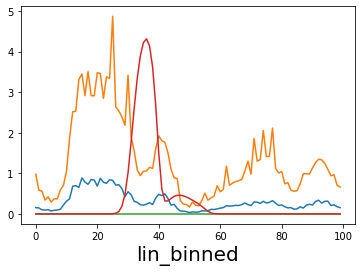

In [325]:
fr_shuffle.loc[174].mean(axis=0).plot()
fr_shuffle.loc[174].quantile(0.99,axis=0).plot()
fr_shuffle.loc[174].quantile(0.01,axis=0).plot()
fr_map_trial_df.loc[174].loc[:,17].plot()

In [195]:
count_unstack = count_trial_df.unstack()

In [207]:
occu_roll_df =pd.DataFrame(occu_roll,index=count_unstack.columns)

In [211]:
count_unstack

0                                                   ...   32       \
        0    1     2     3    4    5     6    7    8    9   ...   90   91   
1.0    0.0  0.0   0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...  0.0  0.0   
2.0    0.0  0.0   0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...  0.0  0.0   
3.0    0.0  0.0   0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...  0.0  0.0   
27.0   0.0  5.0  19.0  44.0  0.0  6.0  14.0  2.0  1.0  3.0  ...  1.0  0.0   
29.0   0.0  2.0   7.0   0.0  6.0  4.0   5.0  0.0  0.0  0.0  ...  0.0  0.0   
...    ...  ...   ...   ...  ...  ...   ...  ...  ...  ...  ...  ...  ...   
476.0  0.0  0.0   0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...  0.0  0.0   
477.0  0.0  0.0   0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...  0.0  0.0   
478.0  0.0  0.0   0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...  0.0  0.0   
479.0  0.0  0.0   0.0   4.0  0.0  0.0   0.0  0.0  0.0  0.0  ...  0.0  0.0   
480.0  0.0  0.0   0.0   0.0  0.0  0.0   0.0  1.0  0.0  0.0  ...  0.0  0.0   

                                                 
        92   93   94   95   96   97    98    99  
1.0    0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  
2.0    0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  
3.0    0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  
27.0   0.0  2.0  0.0  5.0  5.0  4.0  23.0  18.0  
29.0   0.0  0.0  0.0  0.0  0.0  0.0   1.0   2.0  
...    ...  ...  ...  ...  ...  ...   ...   ...  
476.0  0.0  0.0  0.0  0.0  0.0  3.0   9.0   0.0  
477.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  
478.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  
479.0  0.0  0.0  0.0  0.0  3.0  1.0   8.0  15.0  
480.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  

[422 rows x 3300 columns]

In [218]:
count_sum_no_smth = count_trial_df.sum(axis=1).unstack()

In [220]:
occu_roll_sum=occu_roll_df.groupby(level=1).sum()

In [227]:
fr_shuffle = np.einsum('nb,bc->nbc',count_sum_no_smth.values, 1/occu_roll_sum)

In [229]:
occu_roll_sum

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,30.738599,10.397206,1.733931,4.543231,5.802953,3.156521,20.959429,1.733931,5.187484,1.730049,...,7.730401,12.559515,25.445491,2.821315,3.780159,2.015444,16.816836,3.894925,4.422567,7.149466
1,28.962331,15.278675,1.741857,3.771684,6.823042,2.821315,26.282523,1.741857,4.470685,1.733931,...,7.156768,14.951859,21.421761,2.856328,3.794569,1.838516,17.358998,4.696845,4.321808,4.768721
2,25.445491,20.959429,1.750768,3.156521,7.874517,2.856328,29.854748,1.750768,4.003869,1.741857,...,6.708950,16.816836,17.824401,3.381960,4.062491,1.765092,16.191539,5.404573,4.261537,3.249055
3,21.421761,26.282523,1.760560,2.821315,8.691851,3.381960,30.738599,1.760560,3.780159,1.750768,...,6.387577,17.358998,15.027657,4.610108,4.601800,1.736969,13.570881,5.802212,4.299768,2.417043
4,17.824401,29.854748,1.774133,2.856328,9.046807,4.610108,28.962331,1.774133,3.794569,1.760560,...,6.162850,16.191539,12.972351,6.849917,5.386399,1.730049,10.268813,5.753244,4.521267,2.015444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,10.397206,2.821315,2.015444,4.696845,4.321808,5.802212,3.381960,2.015444,9.046807,2.417043,...,12.972351,6.299107,20.959429,5.753244,7.175022,10.268813,7.623683,1.993779,5.457270,16.816836
96,15.278675,2.856328,1.838516,5.404573,4.261537,5.753244,4.610108,1.838516,8.845123,2.015444,...,11.438408,7.126609,26.282523,5.278336,6.123646,7.149466,9.277652,2.112910,5.152971,17.358998
97,20.959429,3.381960,1.765092,5.802212,4.299768,5.278336,6.849917,1.765092,8.157503,1.838516,...,10.234801,7.623683,29.854748,4.543231,5.187484,4.768721,10.468775,2.316649,4.886206,16.191539
98,26.282523,4.610108,1.736969,5.753244,4.521267,4.543231,10.397206,1.736969,7.175022,1.765092,...,9.249577,9.277652,30.738599,3.771684,4.470685,3.249055,12.559515,2.658489,4.686187,13.570881


In [231]:
shuffle_cols = pd.MultiIndex.from_product([occu_roll_sum.index,occu_roll_sum.columns])
fr_shuffle=pd.DataFrame(fr_shuffle.reshape(fr_shuffle.shape[0],-1),index=count_sum_no_smth.index,columns=shuffle_cols)

<AxesSubplot:>

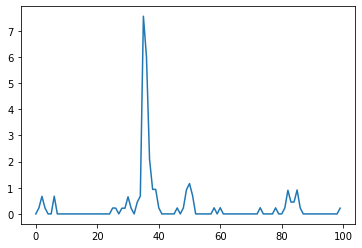

In [237]:
fr_shuffle.groupby(axis=1,level=0).mean().loc[174].plot()

In [226]:
fr_shuffle = pd.DataFrame(fr_shuffle,index=count_sum_no_smth.index,columns=count_sum_no_smth.columns)

ValueError: Must pass 2-d input. shape=(422, 100, 1000)

In [124]:
dt = 0.1
scipy.stats.poisson.ppf(0.99,fr_map_trial_df.loc[174].mean().mean() * dt) / dt

10.0

In [123]:
scipy.stats.poisson.pmf(1,1)

0.36787944117144233

In [93]:
fr_map_trial_df

0    1    2         3         4         5    6    7         8   \
1.0   0   0.0  0.0  0.0  0.000000  0.000000  0.000000  0.0  0.0  0.000000   
      1   0.0  0.0  0.0  0.000000  0.000000  0.000000  0.0  0.0  0.000000   
      2   0.0  0.0  0.0  0.000000  0.000000  0.000000  0.0  0.0  0.000000   
      3   0.0  0.0  0.0  0.000000  0.000000  0.000000  0.0  0.0  0.000000   
      4   0.0  0.0  0.0  0.000000  0.000000  0.000000  0.0  0.0  0.000000   
...       ...  ...  ...       ...       ...       ...  ...  ...       ...   
480.0 95  0.0  0.0  0.0  1.075058  0.476534  0.054399  0.0  0.0  0.002772   
      96  0.0  0.0  0.0  0.409300  0.187327  0.014905  0.0  0.0  0.000000   
      97  0.0  0.0  0.0  0.134418  0.063323  0.003650  0.0  0.0  0.000000   
      98  0.0  0.0  0.0  0.037911  0.018508  0.000648  0.0  0.0  0.000000   
      99  0.0  0.0  0.0  0.010921  0.005706  0.000000  0.0  0.0  0.000000   

                9   ...        23   24   25        26        27        28  \
1.0   0   0.000000  ...  0.000000  0.0  0.0  0.000000  0.000000  0.000000   
      1   0.000000  ...  0.000000  0.0  0.0  0.000000  0.000000  0.000000   
      2   0.000000  ...  0.000000  0.0  0.0  0.000000  0.000000  0.000000   
      3   0.000000  ...  0.000000  0.0  0.0  0.000000  0.000000  0.000000   
      4   0.000000  ...  0.000000  0.0  0.0  0.000000  0.000000  0.000000   
...            ...  ...       ...  ...  ...       ...       ...       ...   
480.0 95  0.018120  ...  0.121499  0.0  0.0  0.005702  0.035985  0.007560   
      96  0.003546  ...  0.029357  0.0  0.0  0.000000  0.007788  0.000591   
      97  0.000000  ...  0.005696  0.0  0.0  0.000000  0.001017  0.000000   
      98  0.000000  ...  0.000000  0.0  0.0  0.000000  0.000000  0.000000   
      99  0.000000  ...  0.000000  0.0  0.0  0.000000  0.000000  0.000000   

                29   30        31        32  
1.0   0   0.000000  0.0  0.000000  1.276029  
      1   0.000000  0.0  0.000000  1.010956  
      2   0.000000  0.0  0.000000  0.706983  
      3   0.000000  0.0  0.000000  0.500585  
      4   0.000000  0.0  0.000000  0.391239  
...            ...  ...       ...       ...  
480.0 95  0.053002  0.0  0.099032  0.001386  
      96  0.011011  0.0  0.031307  0.000000  
      97  0.001781  0.0  0.008732  0.000000  
      98  0.000287  0.0  0.002201  0.000000  
      99  0.000000  0.0  0.000626  0.000000  

[42200 rows x 33 columns]

<AxesSubplot:>

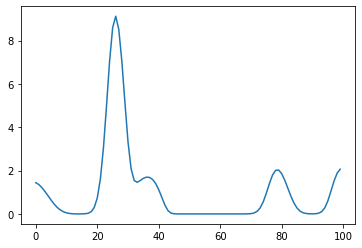

In [92]:
fr_map_trial_df.loc[174].loc[:,0].plot()

<AxesSubplot:xlabel='lin_binned'>

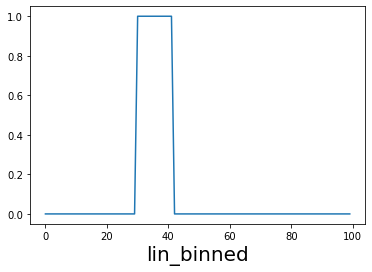

In [83]:
field_res_d[0,0]['bound_isfield'].loc[174].astype(int).plot()

In [35]:
reload(pf)

<module 'place_field_analysis' from '/mnt/home/szheng/projects/util_code/place_field_analysis.py'>

In [140]:
count_trial_df = pf.fr_map_trial_to_df(fr_map_dict[0][1],cell_cols_d['pyr'])

In [84]:
fr_map_trial_df = pf.fr_map_trial_to_df(fr_map_dict[0][0],cell_cols_d['pyr'])

res_df = pf.get_field_params_trial(fr_map_trial_df,field_res_d[0,0]['all_fields'])

<AxesSubplot:xlabel='lin_binned'>

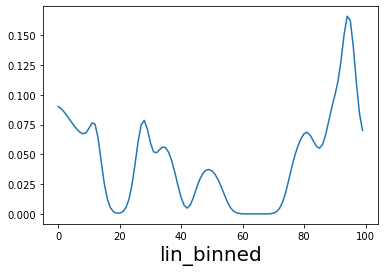

In [32]:
%matplotlib inline
fr_map_d[0,0].loc[104].plot()

In [88]:
res_df.loc['center'].loc[174].loc[0]

0     34.575605
1     31.583063
2           NaN
3     31.253266
4     36.287574
5     36.174008
6     36.525874
7     36.383846
8     35.738812
9     34.673185
10    36.900414
11    35.601929
12    35.627175
13    36.025231
14    34.789467
15    36.445832
16    35.529255
17    35.440567
18    36.800468
19    34.739498
20    35.186068
21    36.636690
22    35.060621
23    38.743561
24    36.852683
25    34.407630
26    35.699790
27    36.228909
28    35.465741
29          NaN
30    36.687337
31    35.343378
32    34.013601
Name: 0, dtype: float64

<AxesSubplot:>

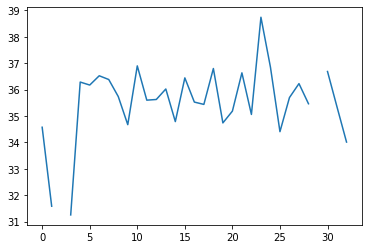

In [87]:
res_df.loc['center'].loc[174].loc[0].plot()

<AxesSubplot:xlabel='lin_binned'>

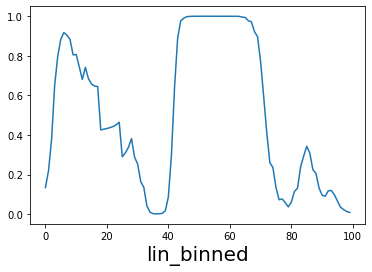

In [41]:
field_res_d[0,0]['pvals_df'].loc[107].plot()

In [47]:
# just using com!

In [57]:
tt=0
fr_map_trial = fr_map_dict[tt][0]
fr_map = fr_map_d[(0,tt)]

In [58]:
pos_l = np.arange(fr_map_trial.shape[1])
com = np.einsum('npt,p->nt',fr_map_trial,pos_l) / np.sum(pos_l)

In [60]:
com_df = pd.DataFrame(com,index=fr_map.index,columns=fr_map_trial_df.columns)

<AxesSubplot:>

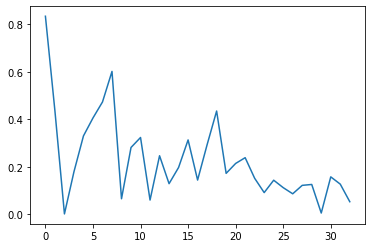

In [63]:
com_df.loc[174].plot()

In [ ]:
com_

In [49]:
fr_map_trial_df.groupby(level=0).apply(lambda: )

0    1    2         3         4         5    6    7         8   \
1.0   0   0.0  0.0  0.0  0.000000  0.000000  0.000000  0.0  0.0  0.000000   
      1   0.0  0.0  0.0  0.000000  0.000000  0.000000  0.0  0.0  0.000000   
      2   0.0  0.0  0.0  0.000000  0.000000  0.000000  0.0  0.0  0.000000   
      3   0.0  0.0  0.0  0.000000  0.000000  0.000000  0.0  0.0  0.000000   
      4   0.0  0.0  0.0  0.000000  0.000000  0.000000  0.0  0.0  0.000000   
...       ...  ...  ...       ...       ...       ...  ...  ...       ...   
480.0 95  0.0  0.0  0.0  1.075058  0.476534  0.054399  0.0  0.0  0.002772   
      96  0.0  0.0  0.0  0.409300  0.187327  0.014905  0.0  0.0  0.000000   
      97  0.0  0.0  0.0  0.134418  0.063323  0.003650  0.0  0.0  0.000000   
      98  0.0  0.0  0.0  0.037911  0.018508  0.000648  0.0  0.0  0.000000   
      99  0.0  0.0  0.0  0.010921  0.005706  0.000000  0.0  0.0  0.000000   

                9   ...        23   24   25        26        27        28  \
1.0   0   0.000000  ...  0.000000  0.0  0.0  0.000000  0.000000  0.000000   
      1   0.000000  ...  0.000000  0.0  0.0  0.000000  0.000000  0.000000   
      2   0.000000  ...  0.000000  0.0  0.0  0.000000  0.000000  0.000000   
      3   0.000000  ...  0.000000  0.0  0.0  0.000000  0.000000  0.000000   
      4   0.000000  ...  0.000000  0.0  0.0  0.000000  0.000000  0.000000   
...            ...  ...       ...  ...  ...       ...       ...       ...   
480.0 95  0.018120  ...  0.121499  0.0  0.0  0.005702  0.035985  0.007560   
      96  0.003546  ...  0.029357  0.0  0.0  0.000000  0.007788  0.000591   
      97  0.000000  ...  0.005696  0.0  0.0  0.000000  0.001017  0.000000   
      98  0.000000  ...  0.000000  0.0  0.0  0.000000  0.000000  0.000000   
      99  0.000000  ...  0.000000  0.0  0.0  0.000000  0.000000  0.000000   

                29   30        31        32  
1.0   0   0.000000  0.0  0.000000  1.276029  
      1   0.000000  0.0  0.000000  1.010956  
      2   0.000000  0.0  0.000000  0.706983  
      3   0.000000  0.0  0.000000  0.500585  
      4   0.000000  0.0  0.000000  0.391239  
...            ...  ...       ...       ...  
480.0 95  0.053002  0.0  0.099032  0.001386  
      96  0.011011  0.0  0.031307  0.000000  
      97  0.001781  0.0  0.008732  0.000000  
      98  0.000287  0.0  0.002201  0.000000  
      99  0.000000  0.0  0.000626  0.000000  

[42200 rows x 33 columns]

In [68]:
min_rate = 1
fr_map_trial_df_swap= fr_map_trial_df.stack().swaplevel(1,2).unstack()
fr_map_peaks = fr_map_trial_df_swap.apply(lambda x:scipy.signal.find_peaks(x,height=min_rate)[0],axis=1)

In [69]:
fr_map_peaks.loc[174]

0     [26, 36, 79]
1         [29, 84]
2               []
3             [29]
4         [37, 85]
5         [36, 84]
6             [37]
7         [37, 83]
8             [35]
9             [33]
10            [38]
11              []
12            [35]
13            [36]
14            [35]
15            [37]
16            [35]
17            [36]
18            [38]
19            [35]
20            [35]
21            [38]
22            [35]
23            [40]
24            [38]
25            [34]
26            [35]
27            [37]
28            [36]
29              []
30              []
31            [34]
32              []
dtype: object